In [26]:
import os
import cv2
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as patches

import csv
import time
import operator

from skimage import io, filters, morphology, measure
from skimage.measure import label,  regionprops
from scipy import ndimage

In [17]:
# Get count of number of files in this folder and all subfolders
def get_num_files(path):
  
    petal_detection_files = {}
    if not os.path.exists(path):
        return 0
    for r, d, files in os.walk(path):
                
        for file in files:
            if 'gray' in file:
                petal_detection_files[r] = os.path.join(r, file)
            
    return petal_detection_files

In [18]:
petal_source_db = get_num_files(r'.\..\Storage\preview_filtered_flowers_for_petals')

In [19]:
for k, v in petal_source_db.items():
    print(k, end =" ")
    print(v)

.\..\Storage\preview_filtered_flowers_for_petals\98 .\..\Storage\preview_filtered_flowers_for_petals\98\gray.png
.\..\Storage\preview_filtered_flowers_for_petals\96 .\..\Storage\preview_filtered_flowers_for_petals\96\gray.png
.\..\Storage\preview_filtered_flowers_for_petals\29 .\..\Storage\preview_filtered_flowers_for_petals\29\gray.png
.\..\Storage\preview_filtered_flowers_for_petals\74 .\..\Storage\preview_filtered_flowers_for_petals\74\gray.png
.\..\Storage\preview_filtered_flowers_for_petals\80 .\..\Storage\preview_filtered_flowers_for_petals\80\gray.png
.\..\Storage\preview_filtered_flowers_for_petals\26 .\..\Storage\preview_filtered_flowers_for_petals\26\gray.png
.\..\Storage\preview_filtered_flowers_for_petals\1 .\..\Storage\preview_filtered_flowers_for_petals\1\gray.png
.\..\Storage\preview_filtered_flowers_for_petals\9 .\..\Storage\preview_filtered_flowers_for_petals\9\gray.png
.\..\Storage\preview_filtered_flowers_for_petals\93 .\..\Storage\preview_filtered_flowers_for_petals

In [4]:
oxford102_labels = pd.read_csv('oxford102_flower_dataset_labels.txt', delimiter='\t', header=None, names=['Names'])
# Image labels are 1 based, changed the index of the image database label
oxford102_labels.index = np.arange(1, len(oxford102_labels) + 1)
print(oxford102_labels)
print()
print("Test Print: FLower Name and its unique label")
print(oxford102_labels.loc[77].get('Names'))

                            Names
1                 'pink primrose'
2     'hard-leaved pocket orchid'
3              'canterbury bells'
4                     'sweet pea'
5              'english marigold'
..                            ...
98              'mexican petunia'
99                     'bromelia'
100              'blanket flower'
101             'trumpet creeper'
102             'blackberry lily'

[102 rows x 1 columns]

Test Print: FLower Name and its unique label
 'passion flower'


In [5]:
def Remove_Freq_Values(original_image,filter_size,ratio):
    new_image = np.zeros_like(original_image)
    most_freq = []
    #cv2.calcHist(images, channels, mask, bins, ranges)
    mask = np.zeros(original_image.shape[:2],np.uint8)
    mask[0:,0:filter_size] = 1
    hist = cv2.calcHist([original_image],[0],mask,[256],[0,256])
    for i in range(hist.shape[0]):
        if hist[i][0] >= hist[hist.argmax()][0]/ratio:
            most_freq.append(i)
    
    mask[0:,-filter_size:-1] = 1
    hist = cv2.calcHist([original_image],[0],mask,[256],[0,256])
    mask = np.zeros(original_image.shape[:2],np.uint8)
    for i in range(hist.shape[0]):
        if hist[i][0] >= hist[hist.argmax()][0]/ratio:
            most_freq.append(i)
    
    mask = np.zeros(original_image.shape[:2],np.uint8)
    mask[0:filter_size,0:] = 1
    hist = cv2.calcHist([original_image],[0],mask,[256],[0,256])
    for i in range(hist.shape[0]):
        if hist[i][0] >= hist[hist.argmax()][0]/ratio:
            most_freq.append(i)
    
    mask = np.zeros(original_image.shape[:2],np.uint8)
    mask[-filter_size:-1,0:] = 1
    hist = cv2.calcHist([original_image],[0],mask,[256],[0,256])
    for i in range(hist.shape[0]):
        if hist[i][0] >= hist[hist.argmax()][0]/ratio:
            most_freq.append(i)
    
    #most_freq_ratio = hist[hist.argmax()] / hist.sum()
    print(most_freq)
    for i in range(original_image.shape[0]):
        for j in range(original_image.shape[1]):
            #if hist[original_image[i][j][0]]/hist.sum() < (most_freq_ratio/ratio) and original_hist[original_image[i][j][0]]/original_hist.sum() < 0.05:
            if original_image[i][j][0] not in most_freq:
                new_image[i][j][0] = original_image[i][j][0]
                new_image[i][j][1] = original_image[i][j][1]
                new_image[i][j][2] = original_image[i][j][2]
    if cv2.compare(new_image,original_image,0).all():
        print("Nothing Changed")
    #original_hist = cv2.calcHist([original_image],[0],None,[256],[0,256])
    return new_image

In [6]:
def distance(x1, y1, x2, y2):
    length = math.sqrt(abs((x1 - x2))**2 + abs((y1 - y2))**2)
    return length

In [7]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return x0, y0

In [8]:
def numbers_to_strings(argument): 
    switcher = { 
        0: "Rectangular", 
        1: "Circular", 
        2: "Elliptical", 
    } 
  
    # get() method of dictionary data type returns  
    # value of passed argument if it is present  
    # in dictionary otherwise second argument will 
    # be assigned as default value of passed argument 
    return switcher.get(argument, "nothing")

In [9]:
#Create a csv file to store petals information
with open('flowers_with_petals_info_trial.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Category", "Name", "Petals"])


## Petals Count Algorithm

flower_category: 98
Petals count Algorithm started...
500
Petal regions area:  369221
Petal regions area:  1
Petal Counts:  1
flower_name:  'mexican petunia'
Petal count Algorithm Ended.


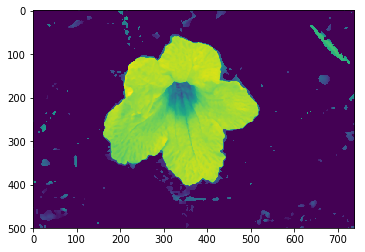

In [34]:
for k,v in petal_source_db.items():
    #print("k: {0}, v: {1}".format(k,v))
    
    if 'gray' in v:
        
        img = cv2.imread(v, -1)
        plt.imshow(img)

        #Get Flower category 
        pattern = '\\'
        truncated = v[v.rfind(pattern, 0, v.rfind(pattern)) + 1 : ]
        index2 = v[v.rfind(pattern, 0, v.rfind(pattern)) + 1 : ].rfind(pattern)
        flower_category = truncated[0: index2]
        print("flower_category: {0}".format(flower_category))

        print("Petals count Algorithm started...")

        #fill image holes
        #im = np.reshape(img*255, (256, 256))
        val = filters.threshold_otsu(img)
        drops = ndimage.binary_fill_holes(img < val)

        label_image = measure.label(drops)
        print(len(drops))

        petals = 0
        for region in regionprops(label_image):
            print("Petal regions area: ", region.area)
            if region.area > 40 :
                petals = petals + 1

        print("Petal Counts: ", petals)

        #Get flower name
        flower_name = oxford102_labels.loc[int(flower_category)].get('Names')
        print("flower_name: {0}".format(flower_name))

        #open the csv file to save the flower category name and petals count
        with open('flowers_with_petals_info_trial.csv', 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([flower_category, flower_name, petals])             


        print("Petal count Algorithm Ended.")

        #Save Petal counted image
        #plt.savefig(r'.\..\Storage\preview_filtered_flowers_for_petals' + "\\" + flower_category + "\\" + k)

        plt.show()
        break
        time.sleep(2)